## Unsupervised learning tutorial: Olshausen & Field sparse coding model

The goal of this tutorial is to introduce a branch of unsupervised learning models, independent component analysis. Independent component analysis is a latent variable model, in which inputs $\mathbf{x}$ are learned through a set of latent variables $\mathbf{z}$ such that inputs (e.g. images) are thought to be constructed through the linear combination of filters represented as columns in a filter basis matrix $\mathbf{A}$:
$$ \mathbf{x} = \mathbf{A} \cdot \mathbf{z} + \epsilon$$
where $\epsilon$ is an additive noise term that is thought to corrupt the input. Individual elements of the vector $\mathbf{z}$ are the contributions of filters to a particular image. If we consider this latent variable model to be represented in the visual cortex then inputs $\mathbf{x}$ would be sensory activations and latents $\mathbf{z}$ would be the activations of neurons in the primary visual cortex. The noise term stands for the presence of sensory noise and it introduces uncertainty about the contribution of filters to the image, i.e. uncertainty about the level of $\mathbf{z}$.

The first goal will be to learn an ICA model on natural images. We will explore the properties of the learned filters ($\mathbf{A}$) and several properties of training.

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image

from tqdm.notebook import tqdm
import scipy.io as sio
import os.path as path
import requests

In [2]:
np.random.seed(0)

-----

### Helper functions

Here we define several functions necessary to training the model.

**Note:** make sure that the variable *folder* is set properly in the function *loadImages* (this function downloads the set of training images from the web and copies it to *folder*. 

In [3]:
def loadImages(folder="./"):
    
    fname = "IMAGES.mat"
    
    if not path.isfile(folder + fname):
        
        print("Downloading data...")
        r = requests.get("http://www.rctn.org/bruno/sparsenet/" + fname)
        bin_data = r.content
        
        with open(folder + fname, "wb") as imgfile:
            imgfile.write(bin_data)
            
    mat_images = sio.loadmat(folder + fname)
    imgs = mat_images["IMAGES"]
    
    return imgs

In [4]:
def train_of(num_iter, nt_max, sz, num_units, model, imgs):

    error_list = []
    Phi_evol = []
    H, W, num_images = imgs.shape
    eps = 1e-2  # Small value that determines convergence

    for iter_ in tqdm(range(1, num_iter)):
        # Get the coordinates of the upper left corner of clopping image randomly
        beginx = np.random.randint(0, W - sz, batch_size)
        beginy = np.random.randint(0, H - sz, batch_size)

        inputs_list = []

        # Get images randomly
        for i in range(batch_size):
            idx = np.random.randint(0, num_images)
            img = imgs[:, :, idx]
            clop = img[beginy[i] : beginy[i] + sz, beginx[i] : beginx[i] + sz].flatten()
            inputs_list.append(clop - np.mean(clop))

        inputs = np.array(inputs_list)  # Input image patches

        model.initialize_states()  # Reset states
        model.normalize_rows()  # Normalize weights

        # Input an image patch until latent variables are converged
        r_tm1 = model.r  # set previous r (t minus 1)

        for t in range(nt_max):
            # Update r without update weights
            error, r = model(inputs, training=False)
            dr = r - r_tm1

            # Compute norm of r
            dr_norm = np.linalg.norm(dr, ord=2) / (eps + np.linalg.norm(r_tm1, ord=2))
            r_tm1 = r  # update r_tm1

            # Check convergence of r, then update weights
            if dr_norm < eps:
                error, r = model(inputs, training=True)
                break

            # If failure to convergence, break and print error
            if t >= nt_max - 2:
                print("Error at patch:", iter_)
                print(dr_norm)
                break

        error_list.append(model.calculate_total_error(error))  # Append errors
        
        if iter_ % 50 == 0:
            Phi_evol.append(model.Phi)

    return error_list, Phi_evol

In [5]:
def sample_image(imgs, sz):

    H, W, num_images = imgs.shape
    beginx = np.random.randint(0, W - sz, 250)
    beginy = np.random.randint(0, H - sz, 250)
    idx = np.random.randint(0, num_images)
    img = imgs[:, :, idx]
    clop = img[beginy[idx] : beginy[idx] + sz, beginx[idx] : beginx[idx] + sz].flatten()

    return clop

In [6]:
def plot_activations(x, ax=None, show=True):

    fig = plt.subplots(
        nrows=3,
        ncols=1,
        figsize=(8, 20),
        gridspec_kw={"height_ratios": [1, 5, 5]},
    )

    ax1 = plt.subplot(3, 1, 1)
    ax1.imshow(np.reshape(x, (sz, sz)), cmap="gray")
    ax1.axis("off")

    activations = np.dot(np.transpose(model.Phi), np.transpose(x))

    ax2 = plt.subplot(3, 1, 2)
    ax2.stem(activations, use_line_collection=True, linefmt="orange")
    ax2.set_ylabel("activation")
    ax2.set_xlabel("neuron")
    ax1.set_title("example image")
    ax2.set_title("activation of neurons")

    ax3 = plt.subplot(3, 1, 3)
    ax3.hist(activations, bins=20, color="orange")
    ax3.set_title("distribution of neuronal activations")
    ax3.set_xlabel("activation")
    ax3.set_ylabel("count")

    if show:
        plt.show()

-----

### Model definition 

Here we define the Olshausen & Field model of independent component analysis (ICA)

In [7]:
class OlshausenField1996Model:
    def __init__(
        self, num_inputs, num_units, batch_size, lr_r=1e-2, lr_Phi=1e-2, lmda=5e-3
    ):
        self.lr_r = lr_r  # learning rate of r
        self.lr_Phi = lr_Phi  # learning rate of Phi
        self.lmda = lmda  # regularization parameter

        self.num_inputs = num_inputs
        self.num_units = num_units
        self.batch_size = batch_size

        # Weights
        Phi = np.random.randn(self.num_inputs, self.num_units).astype(np.float32)
        self.Phi = Phi * np.sqrt(1 / self.num_units)

        # activity of neurons
        self.r = np.zeros((self.batch_size, self.num_units))

    def initialize_states(self):
        self.r = np.zeros((self.batch_size, self.num_units))

    def normalize_rows(self):
        self.Phi = self.Phi / np.maximum(
            np.linalg.norm(self.Phi, ord=2, axis=0, keepdims=True), 1e-8
        )

    # thresholding function of S(x)=|x|
    def soft_thresholding_func(self, x, lmda):
        return np.maximum(x - lmda, 0) - np.maximum(-x - lmda, 0)

    # thresholding function of S(x)=ln(1+x^2)
    def ln_thresholding_func(self, x, lmda):
        f = 9 * lmda * x - 2 * np.power(x, 3) - 18 * x
        g = 3 * lmda - np.square(x) + 3
        h = np.cbrt(np.sqrt(np.square(f) + 4 * np.power(g, 3)) + f)
        two_croot = np.cbrt(2)  # cubic root of two
        return (1 / 3) * (x - h / two_croot + two_croot * g / (1e-8 + h))

    # thresholding function https://arxiv.org/abs/2003.12507
    def cauchy_thresholding_func(self, x, lmda):
        f = 0.5 * (x + np.sqrt(np.maximum(x ** 2 - lmda, 0)))
        g = 0.5 * (x - np.sqrt(np.maximum(x ** 2 - lmda, 0)))
        return f * (x >= lmda) + g * (x <= -lmda)

    def calculate_total_error(self, error):
        recon_error = np.mean(error ** 2)
        sparsity_r = self.lmda * np.mean(np.abs(self.r))
        return recon_error + sparsity_r

    def __call__(self, inputs, training=True, thresholding_func="soft"):
        # Updates
        error = inputs - self.r @ self.Phi.T

        r = self.r + self.lr_r * error @ self.Phi

        if thresholding_func == "soft":
            self.r = self.soft_thresholding_func(r, self.lmda)
        elif thresholding_func == "ln":
            self.r = self.ln_thresholding_func(r, self.lmda)
        elif thresholding_func == "cauchy":
            self.r = self.cauchy_thresholding_func(r, self.lmda)
        else:
            raise ValueError(
                "Invalid thresholding function. Expected 'soft', 'ln' or 'cauchy'."
            )

        if training:
            error = inputs - self.r @ self.Phi.T
            dPhi = error.T @ self.r
            self.Phi += self.lr_Phi * dPhi

        return error, self.r

-----

### Load input images

In [8]:
# Load images for training
imgs = loadImages()

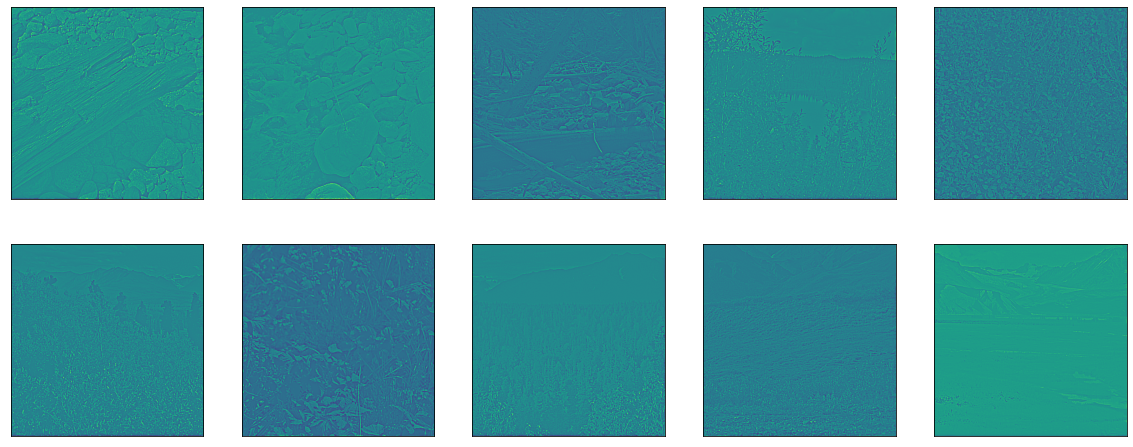

In [9]:
fig, ax = plt.subplots(2, imgs.shape[2] // 2, figsize=(20, 8))
axes = ax.flatten()
for idx, ax_ in enumerate(axes):
    ax_.imshow(imgs[:, :, idx])
    ax_.set_xticks([])
    ax_.set_yticks([])

-----

### Training the model

Below you find the code for training the Olshausen & Field model. 

We take batches of images from the data base and run a number of iterations of the learning procedure. The size of the image patch (*sz*) determines the number of observed variables (or pixels), $\mathrm{length}(\mathbf{x}) = sz^2$, the size of the set latent variables $\mathbf{z}$ is set by *num_units*.

In [10]:
# Simulation constants
num_iter = 501
nt_max = 1000  # Maximum number of simulation time
batch_size = 250  # Batch size
sz = 16  # image patch size
num_units = 100  # number of neurons (units)

In [11]:
model = OlshausenField1996Model(
        num_inputs=sz ** 2, num_units=num_units, batch_size=batch_size
    )

In [12]:
error_list, Phi_evol = train_of(num_iter, nt_max, sz, num_units, model, imgs)

-----

### Task 1.

Explore how the number of iterations (*num_iter*) affects the representation. How many iterations are needed to have filters that resemble Gabor filters? Document your findings.

You can track learning by assessing the cost function:

$$
C = \sum_i (\mathbf{x}_i \mathbf{A} \cdot \mathbf{z}_i)^2 - \sum_i \frac{|\mathbf{x}_i|}{\sigma}
$$

where the index $i$ runs through the image set (in the code $\mathbf{A}$ is denoted by *Phi*). Errors calculated for individual iterations are collected in the variable *error_list*.

### Answer 1.1

**Below you can see how the error changes with the number of iterations. After $\sim$ 50 iterations, the error does not tendentiously decrease further, but fluctuates randomly instead.**

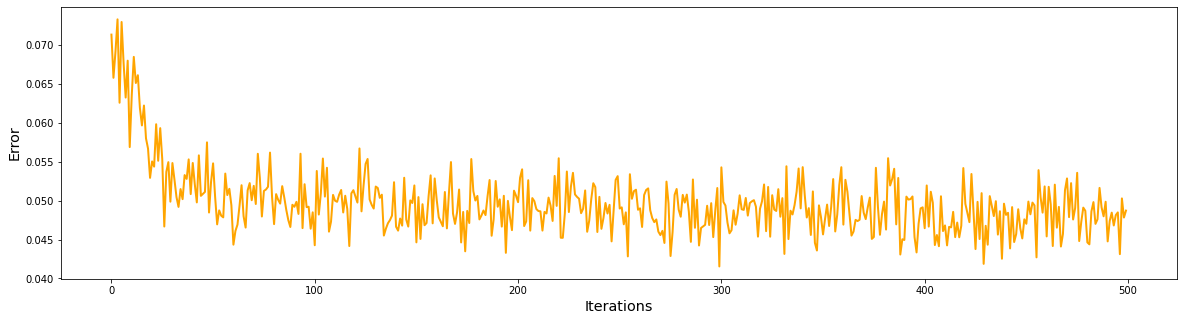

In [13]:
# Plot error
plt.figure(figsize=(20, 5))
plt.ylabel("Error", fontsize="x-large")
plt.xlabel("Iterations", fontsize="x-large")
plt.plot(np.arange(num_iter - 1), np.array(error_list), c="orange", lw=2)

### Answer 1.2

**Characterizing the learned model**: Adaptation to natural stimulus statistics can be identified in how the network parameters are tuned. The critical network parameters are the filters, i.e. the column vectors of the matrix $\mathbf{A}$.

**Here, I plot the resulting filters after each 50th iteration. As you can see, the characteristics of Gabor filters - the sensitivity to a specific direction in a localized region - already start to emerge at $\sim$ 50 iterations and gradually become clearer. After a few hundred iterations, $\mathbf{A}$ completely resembles Gabor filters.**

Text(0.5, 0.98, 'Receptive fields')

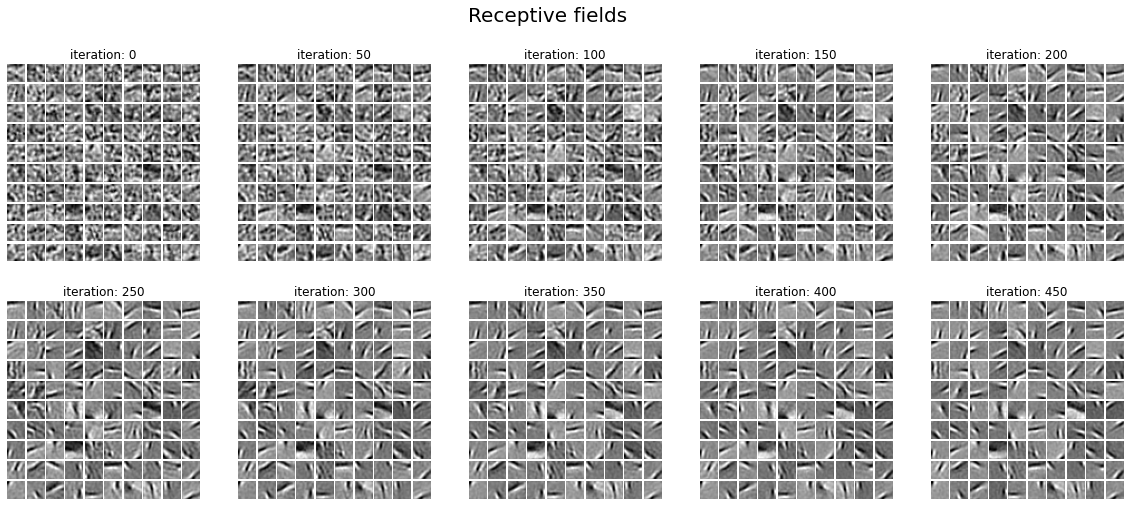

In [14]:
fig = plt.figure(figsize=(20, 8))
outer = gridspec.GridSpec(2, 5, wspace=0.2, hspace=0.2)

for i in range(10):

    ax = plt.Subplot(fig, outer[i])
    ax.set_title(f"iteration: {i * 50}")
    ax.axis("off")
    fig.add_subplot(ax)

    inner = gridspec.GridSpecFromSubplotSpec(
        10, 10, subplot_spec=outer[i], wspace=0.1, hspace=0.1
    )

    for j in range(num_units):
        ax = plt.Subplot(fig, inner[j])
        ax.axis("off")
        ax.imshow(np.reshape(Phi_evol[i][:, j], (sz, sz)), cmap="gray")
        fig.add_subplot(ax)

fig.suptitle("Receptive fields", fontsize=20)

-----

### Reconstructions based on neural activations

In this example we try to explore how much information is stored in neuronal activations about an image. If we train a filter matrix $\mathbf{A}$, then given any image $\mathbf{x}$ the stimulus elicits neural activations $\mathbf{z}$:

$$ \mathbf{A}^{\mathsf{T}}\cdot \mathbf{x} = \mathbf{z}$$

The activations can be both positive and negative (unlike neuronal activities). Those neurons that have a higher level of activation contribute more to the image.

We sample natural image patches from the data base and calculate the activations of these images.

Explore a number of example images!

**I calculate the activations for 1000 sample images.**

**Below, I plot the 6 randomly chosen sample images, along with the respective activations of individual neurons and the distribution of activations.**

In [15]:
sample_size = 10000

In [16]:
sample_images = [sample_image(imgs, 16) for n in range(sample_size)]

In [17]:
activations = [np.dot(np.transpose(model.Phi), np.transpose(x)) for x in sample_images]

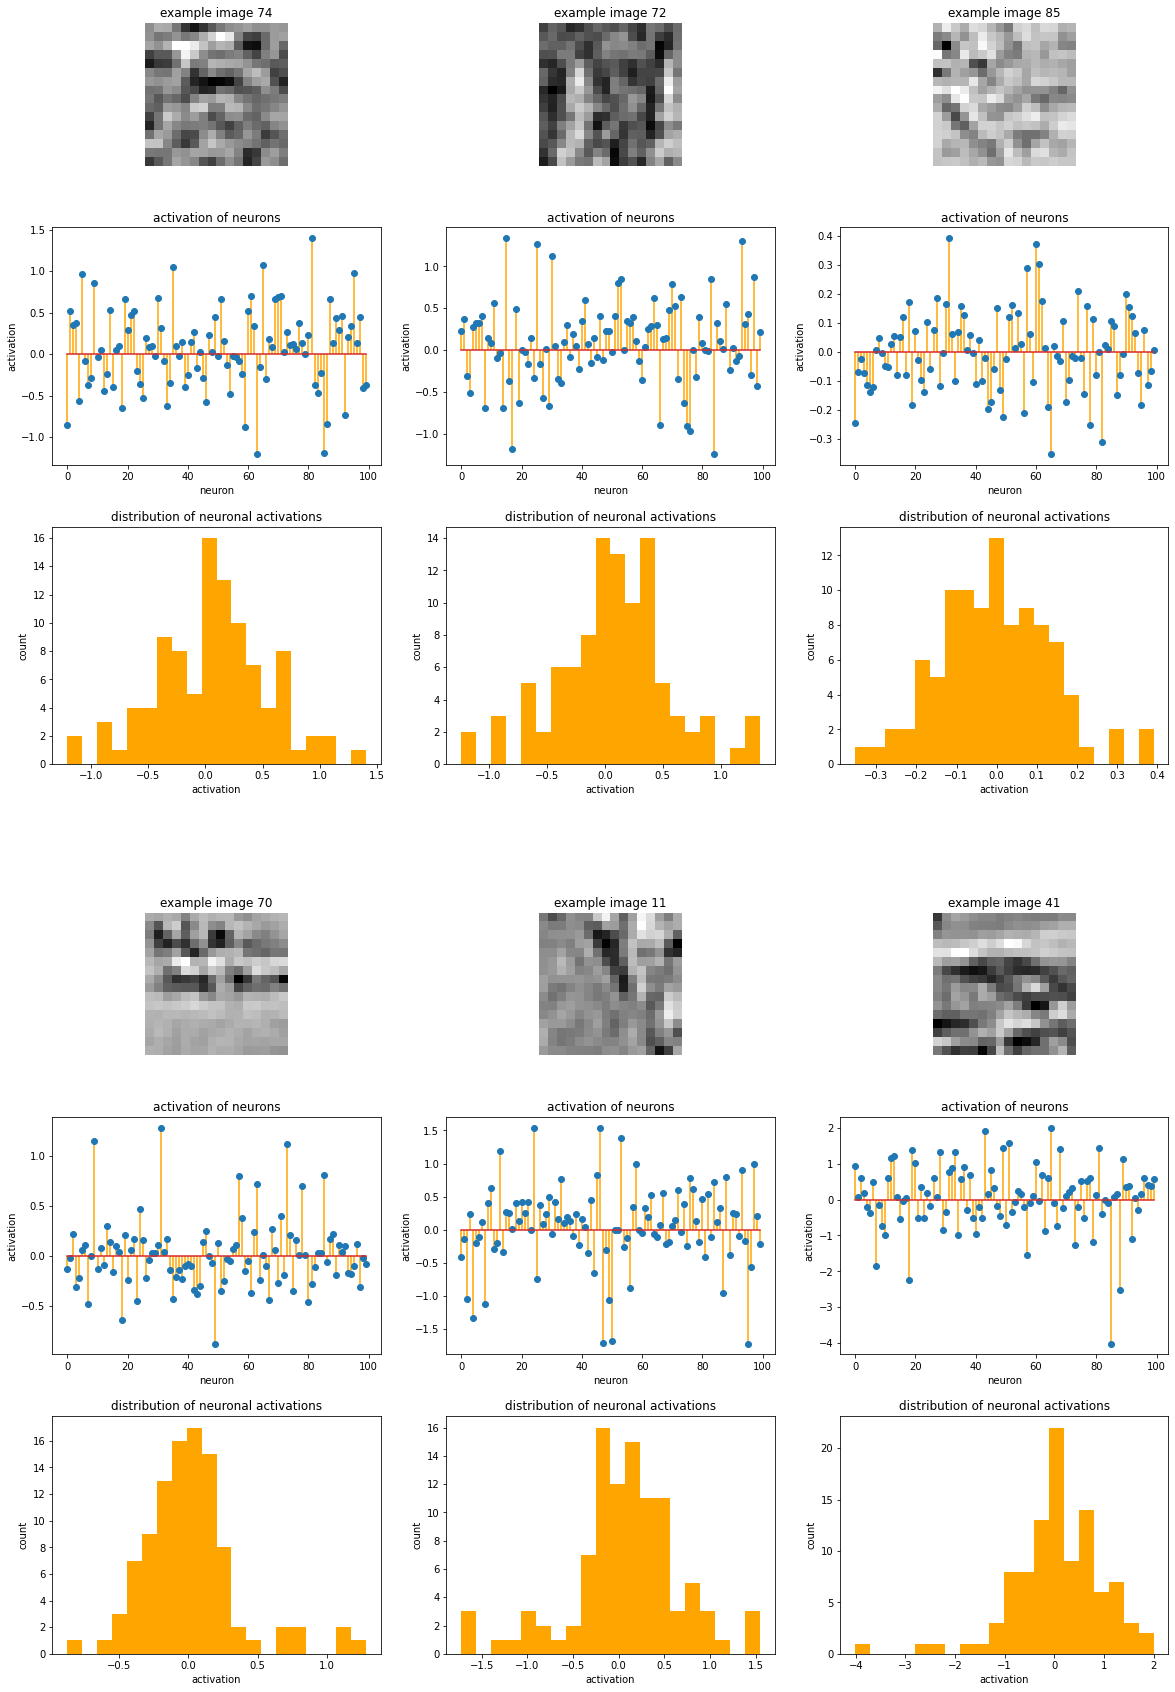

In [18]:
# plot 6 randomly chosen images
fig = plt.figure(figsize=(20, 30))
outer = gridspec.GridSpec(2, 3, wspace=0.2, hspace=0.2)

for i, n in enumerate(np.random.randint(0, num_units, size=6)):

    inner = gridspec.GridSpecFromSubplotSpec(
        3, 1, subplot_spec=outer[i], wspace=0.1, hspace=0.3, height_ratios=[3, 5, 5]
    )

    ax1 = plt.Subplot(fig, inner[0])
    ax1.imshow(np.reshape(sample_images[n], (sz, sz)), cmap="gray")
    ax1.axis("off")
    fig.add_subplot(ax1)

    ax2 = plt.Subplot(fig, inner[1])
    ax2.stem(activations[n], use_line_collection=True, linefmt="orange")
    ax2.set_ylabel("activation")
    ax2.set_xlabel("neuron")
    ax1.set_title(f"example image {n}")
    ax2.set_title("activation of neurons")
    fig.add_subplot(ax2)

    ax3 = plt.Subplot(fig, inner[2])
    ax3.hist(activations[n], bins=20, color="orange")
    ax3.set_title("distribution of neuronal activations")
    ax3.set_xlabel("activation")
    ax3.set_ylabel("count")
    fig.add_subplot(ax3)

-----

### Task 2. 

You can reconstruct the image by combining the filter activations $\mathbf{z}$ with the filters $\mathbf{A}$: $$\hat{x} = \mathbf{A} \cdot \mathbf{z} $$
You can perform this by using the dot product: `np.dot(model.Phi, activations)`.

1. Plot the reconstructed image (`plt.imshow(reconstructed_image, (sz, sz)), cmap="gray")`).


2. Calculate the reconstruction error (`np.linalg.norm(reconstructed_image)`). How good do you think the reconstruction is?


3. You can use a limited subset of the neurons to reconstruct the image, by selecting only a subset of columns in $\mathbf{A}$, i.e. `model.Phi`. For example the reconstruction using only the first two filters would be `np.dot(model.Phi[:, [0, 1, 2]], activations[0, 1, 2])` or alternatively `np.dot(model.Phi[:, range(3)], activations[range(3)])`. Plot the reconstruction error as a function of the number of neurons. Also plot reconstructions with a single neuron, three neurons, ten neurons, or all the neurons.


4. Can you achieve better reconstruction performance with fewer neurons? How? Compare your proposed method to the above method by showing both the reconstructed image for 10 neurons and also the reconstruction error.

### Answer 2.

#### I reconstruct sample images using three different methods:
- using all 100 neurons
- using a randomly chosen subset of neurons
- selecting the neurons with the highest level of activation for the given image (as they are said to contribute more to the image)

#### For all these methods, I calculate the reconstruction error.
*Note: The task description above suggests to use the norm of the reconstruction. I use the **norm of the difference between the original image and reconstruction** instead, as I think the norm of the reconstruction alone is not indicative of the accuracy of the reconstruction.*

In [19]:
def rec_error(original, reconstruction):

    return np.linalg.norm(original - reconstruction, ord=2)

In [20]:
def reconstruction_with_subset(img_num, n_neurons, how="random"):

    if n_neurons == num_units:
        reconstruction = np.dot(model.Phi, activations[img_num])

    else:
        if how == "random":

            neurons = np.sort(
                np.random.choice(np.arange(num_units), size=n_neurons, replace=False)
            )

        elif how == "most_active":

            neurons = np.sort(
                np.argsort(
                    [np.abs(activation).mean() for activation in activations[img_num]]
                )[:n_neurons]
            )

        else:
            raise ValueError(
                "Invalid reconstruction procedure, expected 'random' or 'best'."
            )

        reconstruction = np.dot(model.Phi[:, neurons], activations[img_num][neurons])

    return reconstruction

**Below, I plot the reconstruction error against the number of neurons used for reconstruction for 10 sample images and for both methods that involve only a subset of neurons. In both cases, the reconstruction error first slightly decreases, but above a certain number of neurons it keeps increasing.**

In [21]:
subsample = np.random.randint(0, sample_size, 10).astype(int)
neuron_indices = np.arange(0, num_units)

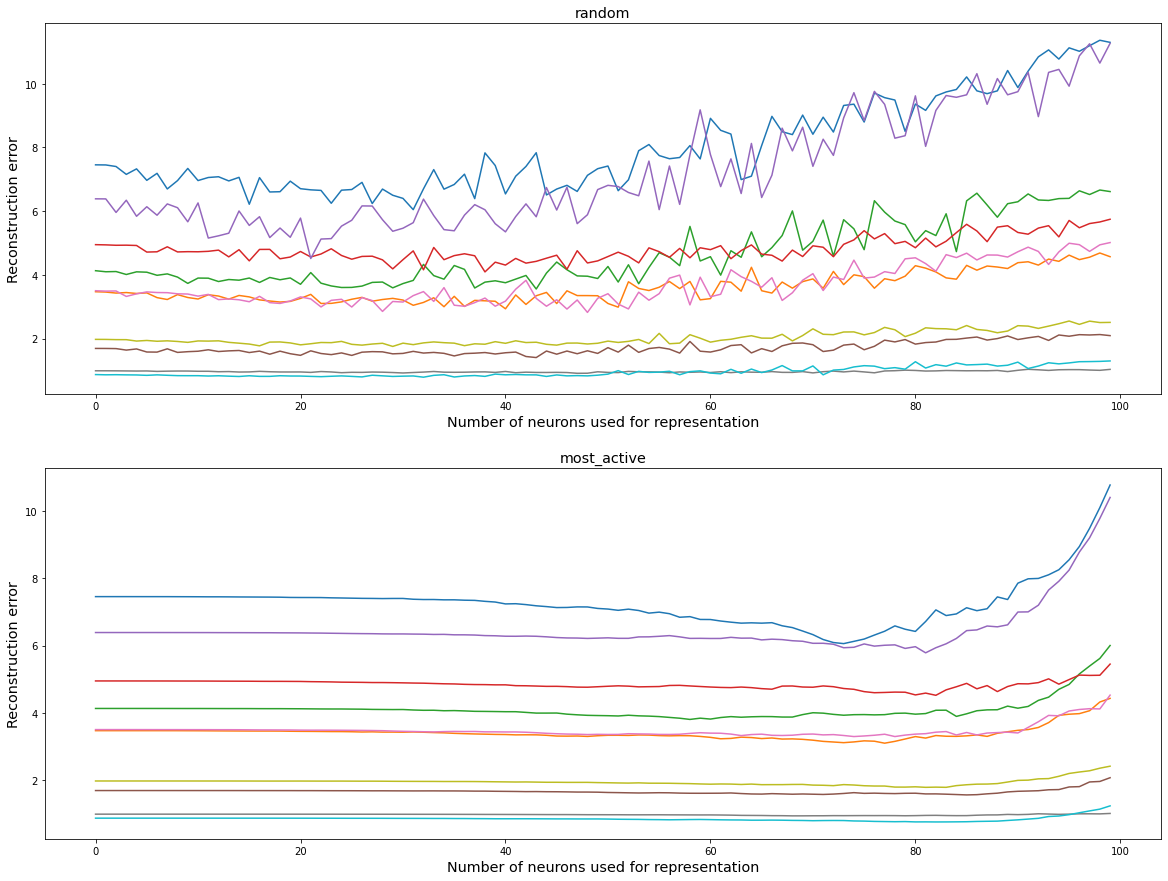

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))

for idx, k in enumerate(["random", "most_active"]):

    for n in subsample:

        ax[idx].plot(
            neuron_indices,
            [
                rec_error(sample_images[n], reconstruction_with_subset(n, s, how=k))
                for s in neuron_indices
            ],
        )

    ax[idx].set_xlabel("Number of neurons used for representation", fontsize="x-large")
    ax[idx].set_ylabel("Reconstruction error", fontsize="x-large")
    ax[idx].set_title(k, fontsize="x-large")

**Here, I reconstruct 10.000 sample images using randomly chosen subset sizes for the "random" and "most active" methods.**

In [23]:
# choose the number of neurons used for reconstruction randomly for each image
subset_sizes = np.random.randint(0, num_units, size=sample_size).astype(int)

In [24]:
# produce the three types of reconstructions described above
reconstructed_images = {
    "all_neurons": [
        reconstruction_with_subset(n, num_units) for n in range(sample_size)
    ],
    "random_subset": [
        reconstruction_with_subset(n, subset_sizes[n]) for n in range(sample_size)
    ],
    "most_active_subset": [
        reconstruction_with_subset(n, subset_sizes[n], how="most_active")
        for n in range(sample_size)
    ],
}

In [25]:
reconstruction_errors = {
    k: [rec_error(sample_images[n], v[n]) for n in range(sample_size)]
    for k, v in reconstructed_images.items()
}

**I plot the reconstruction error against the (randomly chosen) number of neurons used for reconstruction for all sample images. The connection between the two variables is less clear than in the former case. The overall tendency is there, but it is also apparent that the reconstruction error is not heavily determined by the number of neurons in either case.**

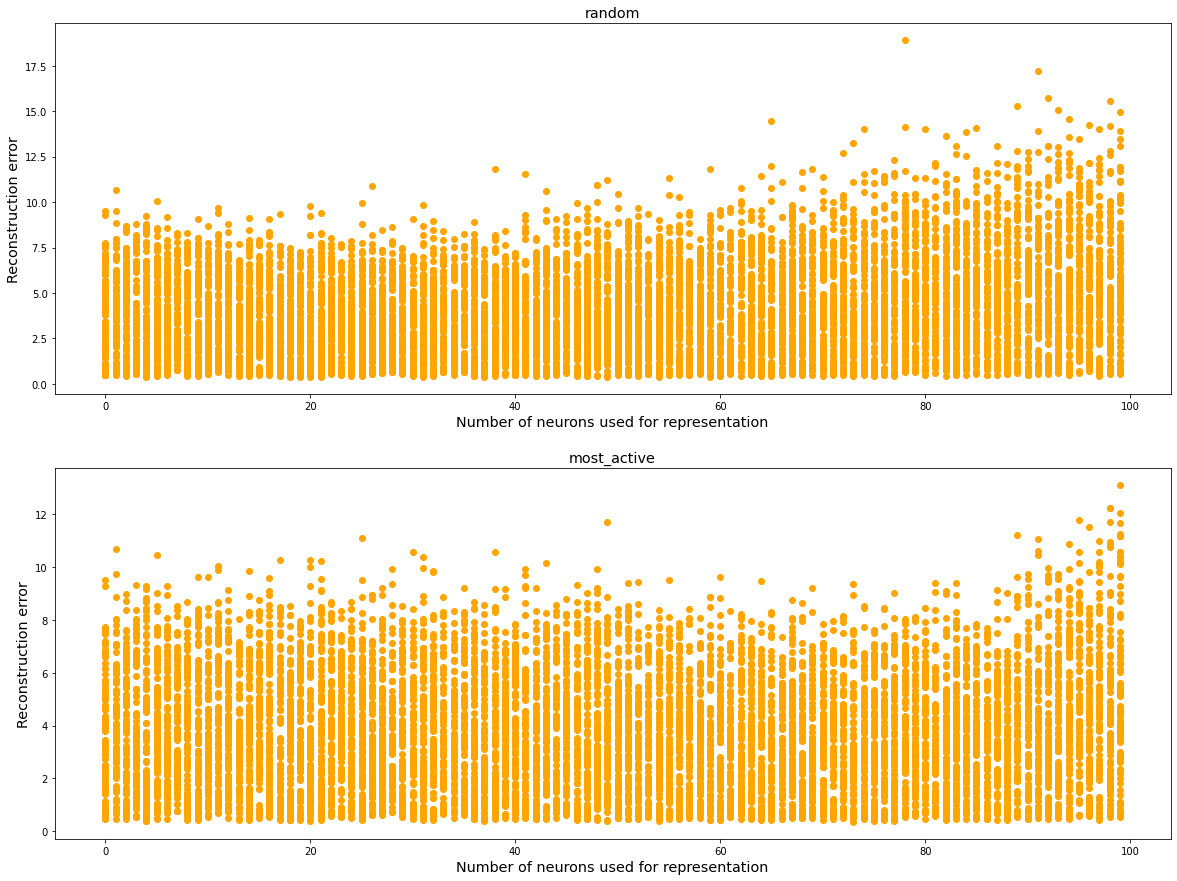

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))

for idx, k in enumerate(["random", "most_active"]):

    ax[idx].scatter(subset_sizes, reconstruction_errors[f"{k}_subset"], c="orange")
    ax[idx].set_xlabel("Number of neurons used for representation", fontsize="x-large")
    ax[idx].set_ylabel("Reconstruction error", fontsize="x-large")
    ax[idx].set_title(k, fontsize="x-large")

**In the figures below, I plot 5 randomly chosen images and their reconstructions with the three different methods. I indicate the respective reconstruction errors, and the subset size, if applicable.**

**At first sight, I would say that the reconstruction error does not entirely capture the quality of the reconstruction. The reconstructions look better for images with more prominent localized shade patterns. However, the overall patterns are roughly preserved in each image. I think this is a good result, as the reconstruction should grasp meaningful details and not noise or insignificant nuances of the image.**

**Solely based on these figures, I cannot draw any clear conclusions about which reconstruction method is better, so I use a linear regression below to assess these methods.**

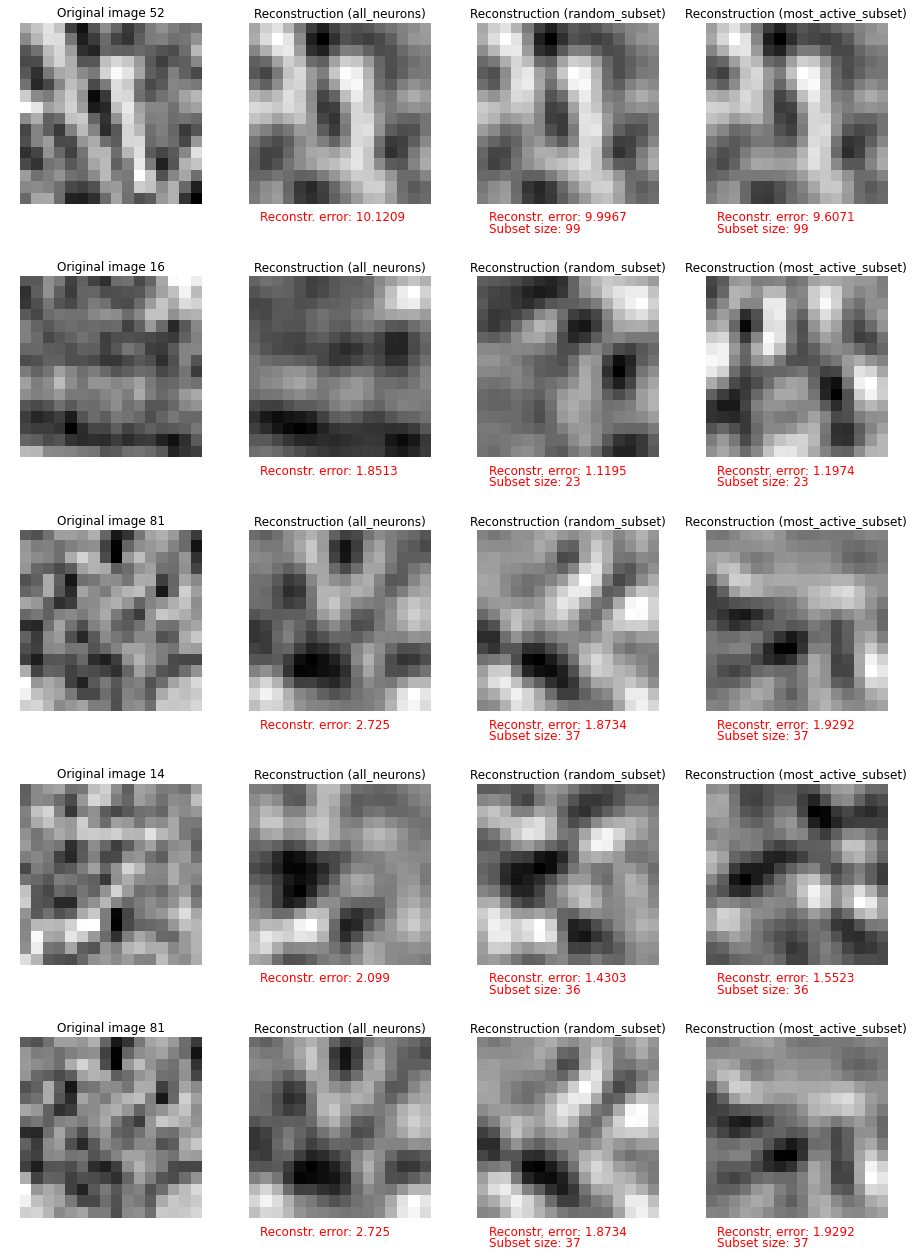

In [27]:
fig = plt.figure(figsize=(16, 22))
outer = gridspec.GridSpec(5, 1, wspace=0.2, hspace=0.4)

for i, n in enumerate(np.random.randint(0, num_units, size=5)):

    ax = plt.Subplot(fig, outer[i])
    ax.axis("off")
    fig.add_subplot(ax)

    inner = gridspec.GridSpecFromSubplotSpec(
        1, 4, subplot_spec=outer[i], wspace=0.1, hspace=0.5
    )

    ax = plt.Subplot(fig, inner[0])
    ax.imshow(np.reshape(sample_images[n], (sz, sz)), cmap="gray")
    ax.axis("off")
    ax.set_title(f"Original image {n}")
    fig.add_subplot(ax)

    for idx, k in enumerate(reconstructed_images.keys()):

        ax = plt.Subplot(fig, inner[idx + 1])
        ax.imshow(np.reshape(reconstructed_images[k][n], (sz, sz)), cmap="gray")
        ax.text(
            0.5,
            17,
            "Reconstr. error: {}".format(round(reconstruction_errors[k][n], 4)),
            fontdict={"fontsize": "large", "color": "r"},
        )

        if "subset" in k:
            ax.text(
                0.5,
                18,
                f"Subset size: {subset_sizes[n]}",
                fontdict={"fontsize": "large", "color": "r"},
            )

        ax.axis("off")
        ax.set_title(f"Reconstruction ({k})")
        fig.add_subplot(ax)

**Here, I fit a linear regression to assess the effect of subset size and reconstruction method on reconstruction error. I control for the standard deviation of pixel values within each sample image, to isolate these effects properly. To capture the complex effect of subset size on the reconstruction error, I include the square of the subset size as well.**

In [28]:
# calculate standard deviation of pixel values
img_stds = np.array([img.std() for img in sample_images])

In [29]:
# randomly select type of reconstruction for each sample image that goes in the regression
reconstruction_types = np.array(
    [np.random.choice(list(reconstructed_images.keys())) for n in range(sample_size)]
)

In [30]:
# define variables of the regression
var_df = (
    pd.DataFrame(
        {
            # "intercept": intercept,
            "std": img_stds,
            "subset_size": subset_sizes.astype(float),
            "subset_size_sq": np.square(subset_sizes).astype(float),
        }
    )
    .merge(
        pd.DataFrame(
            {
                k: (reconstruction_types == k).astype(float)
                for k in reconstructed_images.keys()
            }
        ),
        left_index=True,
        right_index=True,
    )
    .assign(y=[reconstruction_errors[t][n] for n, t in enumerate(reconstruction_types)])
)

In [31]:
# fit regression
reg = LinearRegression().fit(var_df.drop("y", axis=1).values, var_df["y"].values)

In [32]:
reg.score(var_df.drop("y", axis=1).values, var_df["y"].values)

0.8924348729200559

**As you can see below, choosing a random subset, as well as choosing the most active subset reduces the reconstruction error on average (as opposed to using all neurons), and the effect is greater in the case of the "most active subset" method.**

**As I expected, subset size reduces the reconstruction error to a small extent, but its square has a positive coefficient, meaning that using too many neurons slightly corrupts the reconstruction.**

**In conclusion, the best reconstruction can be achived by using a medium-sized subset of the most active neurons.**

In [33]:
pd.DataFrame(
    {k: reg.coef_[idx] for idx, k in enumerate(var_df.columns) if k != "y"},
    index=["coeff"],
)

,std,subset_size,subset_size_sq,all_neurons,random_subset,most_active_subset
coeff,18.832237,-0.012914,0.000199,1.148947,-0.434316,-0.714631


**For illustration, I calculate the optimal subset size based on the regression coefficients, and reconstruct some sample images using the "most active" method with this subset size.**

**Below, I plot the "best reconstructions" along with the reconstructions using all neurons. I again observe that the reconstruction error may not capture the quality of the representation properly. Although the errors are always lower for the "best reconstructions", the other method sometimes produces images that better resemble their original counterparts.**

In [38]:
optimal_subset_size = np.argmin(
    [reg.coef_[1] * s + reg.coef_[2] * s ** 2 for s in range(num_units)]
)

In [39]:
optimal_subset_size

32

In [52]:
best_reconstructions = [
    reconstruction_with_subset(n, optimal_subset_size, how="most_active")
    for n in subsample[:5]
]

In [53]:
best_reconstruction_errors = [
    rec_error(sample_images[n], best_reconstructions[i])
    for i, n in enumerate(subsample[:5])
]

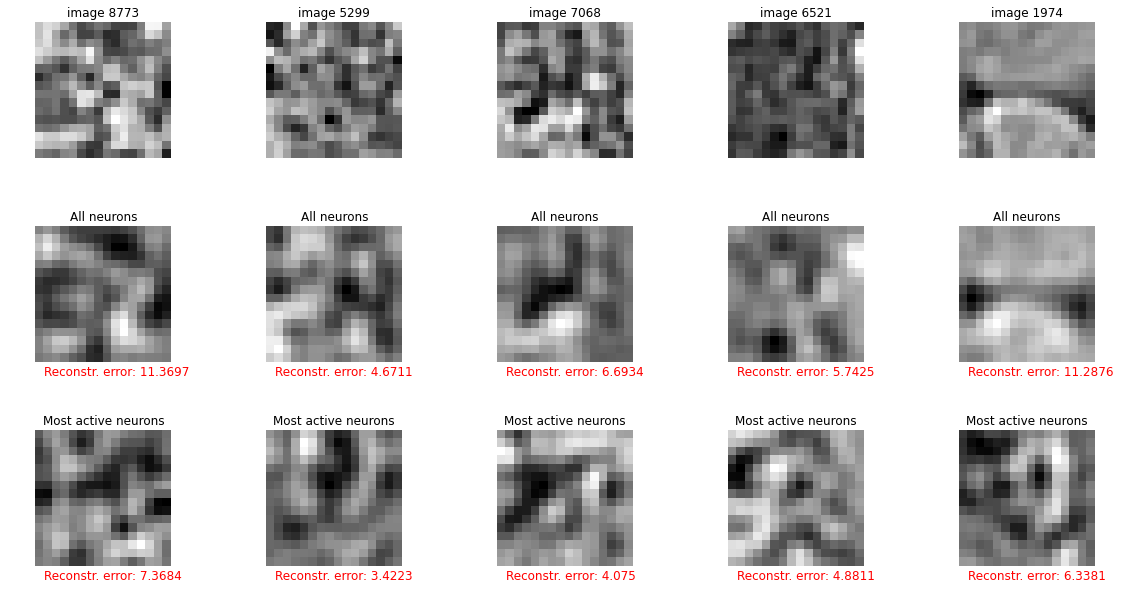

In [59]:
fig = plt.figure(figsize=(20, 10))
outer = gridspec.GridSpec(1, 5, wspace=0.2, hspace=0.4)

for i, n in enumerate(subsample[:5]):

    ax = plt.Subplot(fig, outer[i])
    ax.axis("off")
    fig.add_subplot(ax)

    inner = gridspec.GridSpecFromSubplotSpec(
        3, 1, subplot_spec=outer[i], wspace=0.1, hspace=0.5
    )

    ax = plt.Subplot(fig, inner[0])
    ax.imshow(np.reshape(sample_images[n], (sz, sz)), cmap="gray")
    ax.axis("off")
    ax.set_title(f"image {n}")
    fig.add_subplot(ax)

    ax = plt.Subplot(fig, inner[1])
    ax.imshow(np.reshape(reconstructed_images["all_neurons"][n], (sz, sz)), cmap="gray")
    ax.axis("off")
    ax.set_title(f"All neurons")
    ax.text(
        0.5,
        17,
        "Reconstr. error: {}".format(
            reconstruction_errors["all_neurons"][n].round(4)
        ),
        fontdict={"fontsize": "large", "color": "r"},
    )
    fig.add_subplot(ax)

    ax = plt.Subplot(fig, inner[2])
    ax.imshow(np.reshape(best_reconstructions[i], (sz, sz)), cmap="gray")
    ax.axis("off")
    ax.set_title("Most active neurons")
    ax.text(
        0.5,
        17,
        f"Reconstr. error: {best_reconstruction_errors[i].round(4)}",
        fontdict={"fontsize": "large", "color": "r"},
    )
    fig.add_subplot(ax)